# Limit Cycle Oscillation Analysis Notebook
A notebook for making plots to demonstrate the limit cycle oscillation (LCO) behavior of the fluctuations

## Setup

In [1]:
# %% Imports
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.interpolate

import pickle
import gudhi
import gudhi.representations

from adios2 import FileReader
from netCDF4 import Dataset

from tqdm.notebook import tqdm

from c1lgkt.fields.equilibrium import Equilibrium
from c1lgkt.fields.field_handlers import GaussHermiteFieldHandler, XgcZonalFieldHandler, XgcFieldHandler
from c1lgkt.fields.geometry_handlers import XgcGeomHandler

import c1lgkt.particles.particle_motion as particle_motion
import c1lgkt.particles.particle_tools as particle_tools

In [2]:
# %% Load data files

drive_letter = 'D:'

eq = Equilibrium.from_eqdfile(drive_letter + R'\Documents\IFS\hmode_jet\D3D141451.eqd')
xgcdata = Dataset(drive_letter + R'\Documents\Globus\XGC1.nc')

geom_files = {
    'ele_filename': drive_letter + R'\Documents\IFS\hmode_jet\Seo.eqd.ele',
    'fdmat_filename': drive_letter + R'\Documents\IFS\hmode_jet\fdmat.pkl',
    'min_e_filename': drive_letter + R'\Documents\IFS\hmode_jet\min_E_mat.pkl'
}
geom = XgcGeomHandler(eq, xgcdata, theta0_mode='max_drive', **geom_files)


In [3]:
## Compute zonal flows
zpot = xgcdata['pot00'][:,:]
zpot_psi = xgcdata['psi00'][:]
t = xgcdata['t'][:]

zfield = np.diff(zpot, axis=1) / np.diff(zpot_psi)[np.newaxis,:]
dzfield = np.gradient(zfield, axis=1) / np.diff(zpot_psi)[np.newaxis,:]

# Phase velocity data
ph_data = np.load('./outputs/phase_vel.npz')
u_lstsq = ph_data['u_lstsq']
phimax = ph_data['phimax']

# Load summary statistics
summary_data = np.load('./outputs/summary_data.npz')

In [4]:
# %% Load profile data

# File for one-dimensional profile data
oned_file = drive_letter + R"\Documents\Globus\XGC1_HD3D_elec_rgn1_run4\xgc.oneddiag.bp"

with FileReader(oned_file) as s:
    ## inspect variables
    #vars = s.available_variables()
    #for name, info in vars.items():
    #    print("variable_name: " + name, end=" ")
    #    for key, value in info.items():
    #        print("\t" + key + ": " + value, end=" ")
    #    print()
    #print()

    # Load electron and ion gyrocenter densities
    e_gc_den = s.read('e_gc_density_df_1d', step_selection=[0, 500]).reshape((500,-1))
    i_gc_den = s.read('i_gc_density_df_1d', step_selection=[0, 500]).reshape((500,-1))
    i_T_perp = s.read('i_perp_temperature_df_1d', step_selection=[0, 500]).reshape((500,-1))
    i_en_flux = s.read('i_radial_en_flux_df_1d', step_selection=[0, 500]).reshape((500,-1))

    psi_mks = s.read('psi_mks')

## Analysis and Plots

### Avalanching

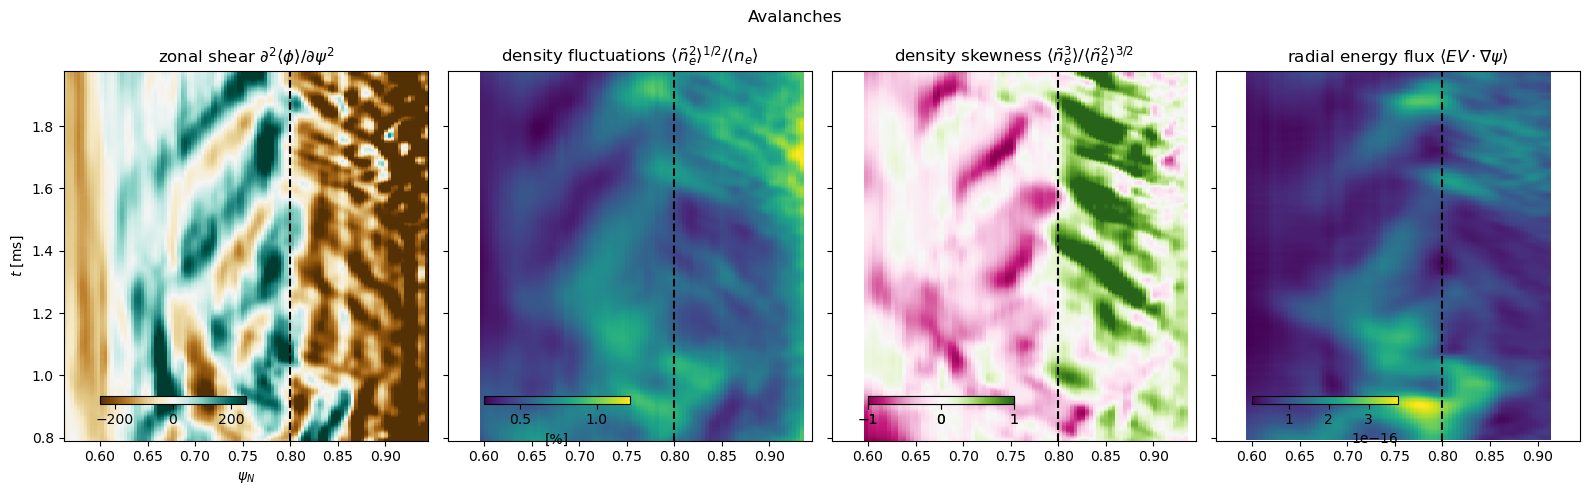

In [5]:
# %% Colormaps of the computed phase velocities and zonal flows
%matplotlib inline

## Plot computed velocities
fig, axs = plt.subplots(1, 4, sharex='all', sharey='all', figsize=(16,5))


tind0 = 200
surf0 = 150
surf1 = 230


pc = axs[0].pcolormesh(zpot_psi[160:-30]/eq.psix, t[tind0-1:]*1e3, -dzfield[tind0:,160:-30]*1e-3, cmap='BrBG', vmin=-250, vmax=250)
axs[0].set_title(R'zonal shear $\partial^2 \langle\phi\rangle / \partial \psi^2$')
cax = axs[0].inset_axes([0.1, 0.1, 0.4, 0.02])
plt.colorbar(pc, cax=cax, orientation='horizontal')


fluctuations = summary_data['e_den_var']/summary_data['e_den_avg']**2
pc = axs[1].pcolormesh(geom.psi_surf[surf0-1:-15]/eq.psix, t[tind0-1:]*1e3, np.sqrt(fluctuations)[tind0:,surf0:-15]*100)
axs[1].set_title(R'density fluctuations $\langle \tilde{n}_e^2 \rangle^{1/2} / \langle n_e \rangle$')
cax = axs[1].inset_axes([0.1, 0.1, 0.4, 0.02])
plt.colorbar(pc, cax=cax, orientation='horizontal', label='[%]')

skewness = summary_data['e_den_skw'] / summary_data['e_den_var']**1.5
pc = axs[2].pcolormesh(geom.psi_surf[surf0-1:-15]/eq.psix, t[tind0-1:]*1e3, skewness[tind0:,surf0:-15], vmin=-1, vmax=1, cmap='PiYG')
axs[2].set_title(R'density skewness $\langle \tilde{n}_e^3 \rangle / \langle \tilde{n}_e^2 \rangle^{3/2}$')
cax = axs[2].inset_axes([0.1, 0.1, 0.4, 0.02])
plt.colorbar(pc, cax=cax, orientation='horizontal')

skewness = summary_data['e_den_skw'] / summary_data['e_den_var']**1.5
pc = axs[2].pcolormesh(geom.psi_surf[surf0-1:-15]/eq.psix, t[tind0-1:]*1e3, skewness[tind0:,surf0:-15], vmin=-1, vmax=1, cmap='PiYG')
axs[2].set_title(R'density skewness $\langle \tilde{n}_e^3 \rangle / \langle \tilde{n}_e^2 \rangle^{3/2}$')
cax = axs[2].inset_axes([0.1, 0.1, 0.4, 0.02])
plt.colorbar(pc, cax=cax, orientation='horizontal')

pc = axs[3].pcolormesh(psi_mks[surf0:surf1]/eq.psix, t[tind0:]*1e3, i_en_flux[tind0:,surf0:surf1])
axs[3].set_title(R'radial energy flux $\langle E V \cdot \nabla \psi \rangle$')
cax = axs[3].inset_axes([0.1, 0.1, 0.4, 0.02])
plt.colorbar(pc, cax=cax, orientation='horizontal')

axs[0].axvline(geom.psi_surf[200]/eq.psix, color='k', linestyle='--')
axs[1].axvline(geom.psi_surf[200]/eq.psix, color='k', linestyle='--')
axs[2].axvline(geom.psi_surf[200]/eq.psix, color='k', linestyle='--')
axs[3].axvline(geom.psi_surf[200]/eq.psix, color='k', linestyle='--')


#axs[2].axvline(geom.psi_surf[190], color='k', linestyle='--')
#axs[2].axvline(geom.psi_surf[220], color='k', linestyle='--')

axs[0].set_xlabel(R'$\psi_N$')
axs[0].set_ylabel(R'$t$ [ms]')

plt.suptitle('Avalanches')

plt.tight_layout()

### Staircases

C:\Users\maple\AppData\Local\Temp\ipykernel_16360\4076543144.py:12: RuntimeWarning: invalid value encountered in log
  e_gc_lne = -np.gradient(np.log(e_gc_den), axis=1) / np.gradient(psi_mks)


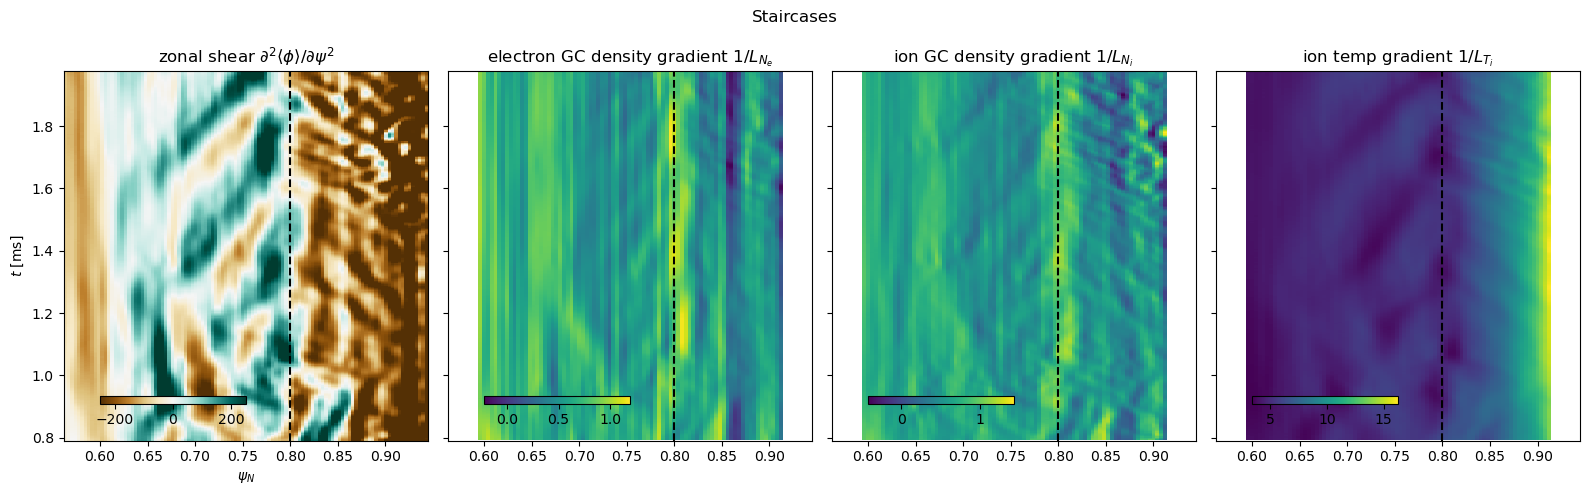

In [6]:
# %% Plot profiles in space-time

fig, axs = plt.subplots(1, 4, sharex='all', sharey='all', figsize=(16,5))
tind0 = 200
surf0 = 150
surf1 = 230

# Set up colorbar
tw_repeated = mpl.cm.twilight(np.mod(np.linspace(0, 12, 256),1))
twr_cmap = mpl.colors.LinearSegmentedColormap.from_list('twilight_repeated', tw_repeated, N=256)

e_gc_lne = -np.gradient(np.log(e_gc_den), axis=1) / np.gradient(psi_mks)
i_gc_lne = -np.gradient(np.log(i_gc_den), axis=1) / np.gradient(psi_mks)
i_T_perp_lne = -np.gradient(np.log(i_T_perp), axis=1) / np.gradient(psi_mks)

pc = axs[0].pcolormesh(zpot_psi[160:-30]/eq.psix, t[tind0-1:]*1e3, -dzfield[tind0:,160:-30]*1e-3, cmap='BrBG', vmin=-250, vmax=250)
axs[0].set_title(R'zonal shear $\partial^2 \langle\phi\rangle / \partial \psi^2$')
cax = axs[0].inset_axes([0.1, 0.1, 0.4, 0.02])
plt.colorbar(pc, cax=cax, orientation='horizontal')

pc = axs[1].pcolormesh(psi_mks[surf0:surf1]/eq.psix, t[tind0:]*1e3, e_gc_lne[tind0:,surf0:surf1])
axs[1].set_title(R'electron GC density gradient $1/L_{N_e}$')
cax = axs[1].inset_axes([0.1, 0.1, 0.4, 0.02])
plt.colorbar(pc, cax=cax, orientation='horizontal')

pc = axs[2].pcolormesh(psi_mks[surf0:surf1]/eq.psix, t[tind0:]*1e3, i_gc_lne[tind0:,surf0:surf1])
axs[2].set_title(R'ion GC density gradient $1/L_{N_i}$')
cax = axs[2].inset_axes([0.1, 0.1, 0.4, 0.02])
plt.colorbar(pc, cax=cax, orientation='horizontal')

pc = axs[3].pcolormesh(psi_mks[surf0:surf1]/eq.psix, t[tind0:]*1e3, i_T_perp_lne[tind0:,surf0:surf1])
axs[3].set_title(R'ion temp gradient $1/L_{T_i}$')
cax = axs[3].inset_axes([0.1, 0.1, 0.4, 0.02])
plt.colorbar(pc, cax=cax, orientation='horizontal')


axs[0].axvline(geom.psi_surf[200]/eq.psix, color='k', linestyle='--')
axs[1].axvline(geom.psi_surf[200]/eq.psix, color='k', linestyle='--')
axs[2].axvline(geom.psi_surf[200]/eq.psix, color='k', linestyle='--')
axs[3].axvline(geom.psi_surf[200]/eq.psix, color='k', linestyle='--')

axs[0].set_xlabel(R'$\psi_N$')
axs[0].set_ylabel(R'$t$ [ms]')

plt.suptitle('Staircases')

plt.tight_layout()

### Phase Space Topology

In [21]:
# %% Generate silhouettes for phase space

tind_s0 = 100
s1_trapped_lower = np.empty(((500-tind_s0)//5, 512))
s0_trapped_lower = np.empty(((500-tind_s0)//5, 512))
s1_passing_lower = np.empty(((500-tind_s0)//5, 512))
s0_passing_lower = np.empty(((500-tind_s0)//5, 512))

SH = gudhi.representations.Silhouette(resolution=512, sample_range=[2.2e8, 3.6e8], weight=lambda x: np.power(np.abs(x[1]-x[0]),2))

for tind in tqdm(range(tind_s0, 500, 5)):
    with open(f'F:/Documents/IFS/hmode_jet/outputs/phase_space_analysis_trapped/persistence_diagram_{tind}.pkl', 'rb') as f:
        p_all = pickle.load(f)

    pp_lower = []
    pn_lower = []
    pp_upper = []
    pn_upper = []

    for p_list in p_all:
        pp_lower.extend(p_list[0])
        pn_lower.extend(p_list[1])
        pp_upper.extend(p_list[2])
        pn_upper.extend(p_list[3])

    p1_lower = np.array(sorted(list(p[1] for p in (pp_lower+pn_lower) if p[0] == 1 and np.isfinite(p[1][1])), key=lambda p: p[0]-p[1]))
    p0_lower = np.array(sorted(list(p[1] for p in (pp_lower+pn_lower) if p[0] == 0 and np.isfinite(p[1][1])), key=lambda p: p[0]-p[1]))

    
    sh = SH.fit_transform([p1_lower])
    s1_trapped_lower[(tind-tind_s0)//5,:] = sh.flatten()

    sh = SH.fit_transform([p0_lower])
    s0_trapped_lower[(tind-tind_s0)//5,:] = sh.flatten()

    """
    with open(f'F:/Documents/IFS/hmode_jet/outputs/phase_space_passing_tda/persistence_diagram_{tind}.pkl', 'rb') as f:
        p_all = pickle.load(f)

    pp_lower = []
    pn_lower = []
    pp_upper = []
    pn_upper = []

    for p_list in p_all:
        pp_lower.extend(p_list[0])
        pn_lower.extend(p_list[1])
        pp_upper.extend(p_list[2])
        pn_upper.extend(p_list[3])

    p1_lower = np.array(sorted(list(p[1] for p in (pp_lower+pn_lower) if p[0] == 1 and np.isfinite(p[1][1])), key=lambda p: p[0]-p[1]))
    p0_lower = np.array(sorted(list(p[1] for p in (pp_lower+pn_lower) if p[0] == 0 and np.isfinite(p[1][1])), key=lambda p: p[0]-p[1]))

    
    sh = SH.fit_transform([p1_lower])
    s1_passing_lower[(tind-tind_s0)//5,:] = sh.flatten()

    sh = SH.fit_transform([p0_lower])
    s0_passing_lower[(tind-tind_s0)//5,:] = sh.flatten()
    """



  0%|          | 0/80 [00:00<?, ?it/s]

In [18]:
s1_den_lower = np.empty(((500-tind_s0)//5, 512))
s0_den_lower = np.empty(((500-tind_s0)//5, 512))

SH_den = gudhi.representations.Silhouette(resolution=512, sample_range=[3.375e19, 3.475e19], weight=lambda x: np.power(np.abs(x[1]-x[0]),3))

for tind in tqdm(range(tind_s0, 500, 5)):
    with open(f'F:/Documents/IFS/hmode_jet/outputs/f3d_tda/persistence_diagram_{tind}.pkl', 'rb') as f:
        p_all = pickle.load(f)

    p_lower = []
    p_upper = []

    for p_list in p_all:
        p_lower.extend(p_list[0])
        p_upper.extend(p_list[1])

    p1_lower = np.array(sorted(list(p[1] for p in (p_lower) if p[0] == 1 and np.isfinite(p[1][1])), key=lambda p: p[0]-p[1]))
    p0_lower = np.array(sorted(list(p[1] for p in (p_lower) if p[0] == 0 and np.isfinite(p[1][1])), key=lambda p: p[0]-p[1]))

    sh = SH_den.fit_transform([p1_lower])
    s1_den_lower[(tind-tind_s0)//5,:] = sh.flatten()

    sh = SH_den.fit_transform([p0_lower])
    s0_den_lower[(tind-tind_s0)//5,:] = sh.flatten()

  0%|          | 0/80 [00:00<?, ?it/s]

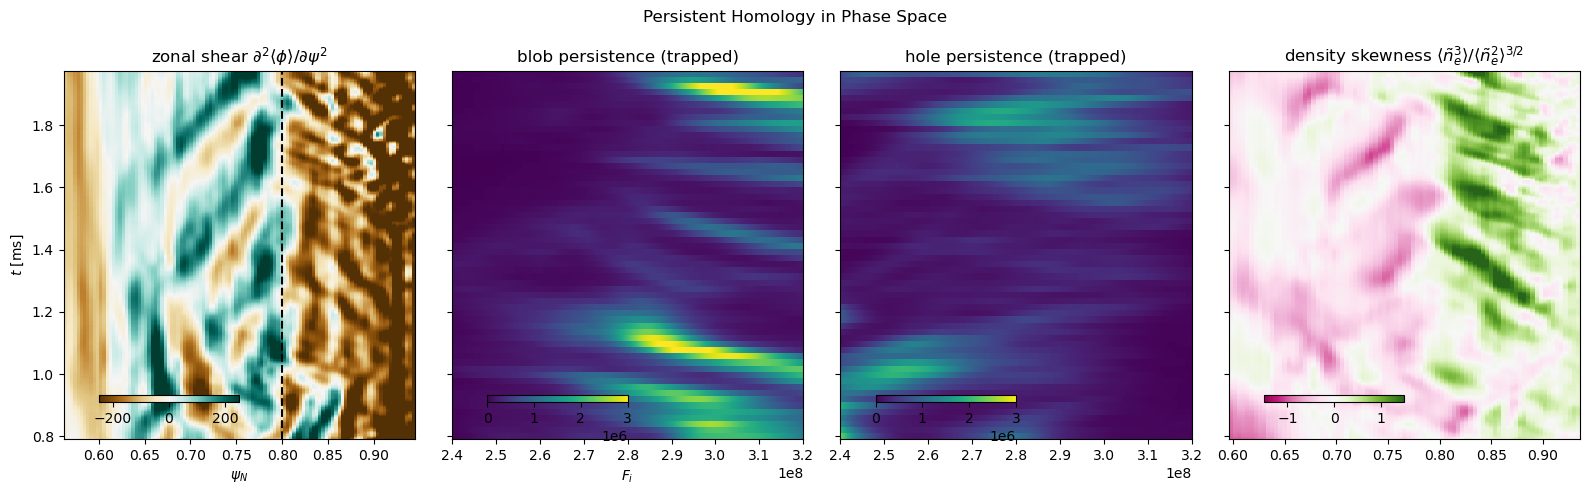

In [19]:
# %% Topological plots

fig, axs = plt.subplots(1, 4, sharey='all', figsize=(16,5))
sind0 = (tind0 - 100)//5
surf0 = 150
surf1 = 230

f_range = np.linspace(2.4e8, 3.2e8, 513)

pc = axs[0].pcolormesh(zpot_psi[160:-30]/eq.psix, t[tind0-1:]*1e3, -dzfield[tind0:,160:-30]*1e-3, cmap='BrBG', vmin=-250, vmax=250)
axs[0].set_title(R'zonal shear $\partial^2 \langle\phi\rangle / \partial \psi^2$')
cax = axs[0].inset_axes([0.1, 0.1, 0.4, 0.02])
plt.colorbar(pc, cax=cax, orientation='horizontal')

pc = axs[1].pcolormesh(f_range, t[tind0-1::5]*1e3, s1_trapped_lower[sind0:,:], vmin=0, vmax=3e6)
axs[1].set_title(R'blob persistence (trapped)')
cax = axs[1].inset_axes([0.1, 0.1, 0.4, 0.02])
plt.colorbar(pc, cax=cax, orientation='horizontal')

pc = axs[2].pcolormesh(f_range, t[tind0-1::5]*1e3, s0_trapped_lower[sind0:,:], vmin=0, vmax=3e6)
axs[2].set_title(R'hole persistence (trapped)')
cax = axs[2].inset_axes([0.1, 0.1, 0.4, 0.02])
plt.colorbar(pc, cax=cax, orientation='horizontal')

#pc = axs[3].pcolormesh(f_range, t[tind0-1::5]*1e3, s1_passing_lower[sind0:,:], vmin=0, vmax=7.5e6)
#axs[3].set_title(R'blob persistence (passing)')
#cax = axs[3].inset_axes([0.1, 0.1, 0.4, 0.02])
#plt.colorbar(pc, cax=cax, orientation='horizontal')

#pc = axs[3].pcolormesh(psi_mks[surf0:surf1]/eq.psix, t[tind0:]*1e3, i_en_flux[tind0:,surf0:surf1])
#axs[3].set_title(R'radial energy flux $\langle E V \cdot \nabla \psi \rangle$')
#cax = axs[3].inset_axes([0.1, 0.1, 0.4, 0.02])
#plt.colorbar(pc, cax=cax, orientation='horizontal')

skewness = summary_data['e_den_skw'] / summary_data['e_den_var']**1.5
pc = axs[3].pcolormesh(geom.psi_surf[surf0-1:-15]/eq.psix, t[tind0-1:]*1e3, skewness[tind0:,surf0:-15], vmin=-1.5, vmax=1.5, cmap='PiYG')
axs[3].set_title(R'density skewness $\langle \tilde{n}_e^3 \rangle / \langle \tilde{n}_e^2 \rangle^{3/2}$')
cax = axs[3].inset_axes([0.1, 0.1, 0.4, 0.02])
plt.colorbar(pc, cax=cax, orientation='horizontal')

axs[0].set_xlabel(R'$\psi_N$')
axs[0].set_ylabel(R'$t$ [ms]')

axs[1].set_xlabel(R'$F_i$')

axs[0].axvline(geom.psi_surf[200]/eq.psix, color='k', linestyle='--')
#axs[1].axvline(2.8e8, color='tab:gray', linestyle='--')
#axs[2].axvline(2.8e8, color='tab:gray', linestyle='--')
#axs[3].axvline(2.8e8, color='tab:gray', linestyle='--')




plt.suptitle('Persistent Homology in Phase Space')

plt.tight_layout()

In [16]:
sind0

20

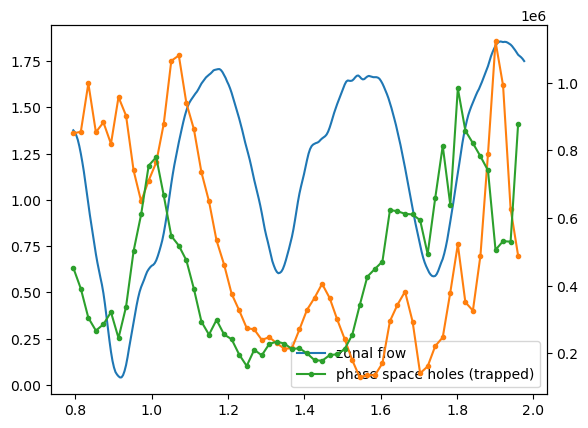

In [20]:
# %% Temporal plots

fig, ax = plt.subplots()

lns1 = ax.plot(t[tind0:]*1e3, zfield[tind0:,200]*1e-3, label='zonal flow')
ax2 = ax.twinx()
lns2 = ax2.plot(t[tind0::5]*1e3, np.average(s1_trapped_lower[sind0:,:],axis=1), label='phase space blobs (trapped)', c='tab:orange', marker='.')
lns2 = ax2.plot(t[tind0::5]*1e3, np.average(s0_trapped_lower[sind0:,:],axis=1), label='phase space holes (trapped)', c='tab:green', marker='.')

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs)


In [69]:
# %% Temporally averaged plots

plt.figure()
plt.plot(zpot_psi[131:-30], np.mean(zfield[tind0:,130:-30], axis=0))

plt.plot(geom.psi_surf[surf0:], np.mean(u_lstsq[tind0:,surf0:], axis=0))

plt.axvline(geom.psi_surf[220], color='k', linestyle='--')
#plt.plot(np.mean(zfield[tind0:,130:-30], axis=0))

[[ 1.         -0.23131884]
 [-0.23131884  1.        ]]


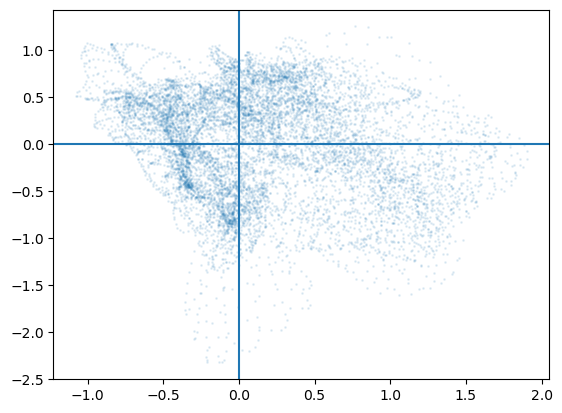

In [ ]:
# %% Scatter Plots
e_den_skwn = summary_data['e_den_skw'] / summary_data['e_den_var']**1.5
i_T_perp_skwn = summary_data['i_T_perp_skw'] / summary_data['i_T_perp_var']**1.5

plt.figure()
plt.scatter(e_den_skwn[250:,180:220].flatten(), i_T_perp_skwn[250:,180:220].flatten(), s=1, alpha=0.1)
plt.axvline()
plt.axhline()

print(np.corrcoef(e_den_skwn[250:,180:220].flatten(), i_T_perp_skwn[250:,180:220].flatten()))

In [119]:
# %% Corner plots

surfc = 196
surfcz = np.searchsorted(zpot_psi, geom.psi_surf[surfc])

data = [
    #(summary_data['e_den_skw'] / summary_data['e_den_var']**1.5)[tind0:,surfc],
    (summary_data['e_den_var'] * 1e-40)[tind0:,surfc],
    zfield[tind0:,surfcz],
    zfield[tind0:,surfcz-5],
]

fig, axs = plt.subplots(len(data)-1, len(data)-1, figsize=(8,8), sharex='col', sharey='row')
for i in range(len(data)-1):
    for j in range(len(data)):
        if i == j:
            #axs[i,j].hist(data[i], bins=30, color='C0', alpha=0.5)
            pass
        elif i < j:
            axs[i,j-1].scatter(data[j], data[i], c=t[tind0:])
            axs[i,j-1].plot(data[j], data[i], alpha=0.1, color='k')
            #axs[i,j].set_xlabel('x')
            #axs[i,j].set_ylabel('y')

plt.tight_layout(pad=0)

In [ ]:
# %% Temporal plots

plt.figure()

plt.plot(t[tind0:], data[1])
plt.twinx()
plt.plot(t[tind0:], data[2], c='tab:orange')


In [45]:
# %% Load persistence diagrams

persistences = []
tinds = np.arange(100, 500, 5)

for tind in tinds:
    with open(f'./outputs/phase_space_tda/persistence_diagram_{tind}.pkl', 'rb') as f:
        persistences.append(pickle.load(f))

In [51]:
# %% Test plotting one of the persistence diagrams
%matplotlib agg


def compact_persistence(p):
    """
    This function takes a persistence diagram and returns numpy arrays of births and deaths suitable
    for plotting
    """
    
    # Put all the data into numpy arrays
    births = np.empty(len(p))
    deaths = np.empty(len(p))
    dims = np.empty(len(p), dtype=int)
    for i, (dim, (b, d)) in enumerate(p):
        births[i] = b
        deaths[i] = d
        dims[i] = dim

    # Sort the data by dimension
    dimsort = np.argsort(dims)
    births = births[dimsort]
    deaths = deaths[dimsort]
    dims = dims[dimsort]

    # Find the first instance of dimension 1
    ind = np.searchsorted(dims, 1)
    # Split the data into dimension 0 and dimension 1
    p0 = births[:ind], deaths[:ind]
    p1 = births[ind:], deaths[ind:]

    # Return the data
    return p0, p1

def plot_persistence(ax, pind):
    pp_lower, pn_lower, pp_upper, pn_upper = persistences[pind]

    p0_lower, p1_lower = compact_persistence(pp_lower + pn_lower)
    p0_upper, p1_upper = compact_persistence(pp_upper + pn_upper)

    ax.set_aspect('equal', adjustable='box')

    ax.scatter( p0_lower[0],  p0_lower[1], c='C0', s=((p0_lower[1]-p0_lower[0])*3e-7)**2, alpha=0.5)
    ax.scatter( p1_lower[0],  p1_lower[1], c='C1', s=((p1_lower[1]-p1_lower[0])*3e-7)**2, alpha=0.5)
    ax.scatter(-p0_upper[0], -p0_upper[1], c='C2', s=((p0_upper[1]-p0_upper[0])*3e-7)**2, alpha=0.5)
    ax.scatter(-p1_upper[0], -p1_upper[1], c='C3', s=((p1_upper[1]-p1_upper[0])*3e-7)**2, alpha=0.5)

    ax.plot([2.4e8, 3.2e8], [2.4e8, 3.2e8], color='k', linestyle='--')


    ax.set_title(f'Persistence diagram at t = {t[tinds[pind]]*1e3:.3f} ms')

    ax.set_xlim(2.3e8, 3.3e8)
    ax.set_ylim(2.3e8, 3.3e8)


for pind in tqdm(range(len(persistences))):
    fig, axs = plt.subplots(1, 2, figsize=(10,6), dpi=100)
    plot_persistence(axs[0], pind)
    

    pc = axs[1].pcolormesh(zpot_psi[160:-30]/eq.psix, t[100-1:]*1e3, -zfield[100:,160:-30]*1e-3)
    axs[1].set_title(R'zonal flows $\partial \langle\phi\rangle / \partial \psi$')
    cax = axs[1].inset_axes([0.1, 0.1, 0.4, 0.02])
    axs[1].axhline(t[tinds[pind]]*1e3, color='tab:red', linestyle='--')
    plt.colorbar(pc, cax=cax, orientation='horizontal', label='[kHz]')

    plt.savefig(f'./outputs/phase_space_tda/persistence_diagram_{tinds[pind]}.png', dpi=100)

    plt.close(fig)

  0%|          | 0/80 [00:00<?, ?it/s]

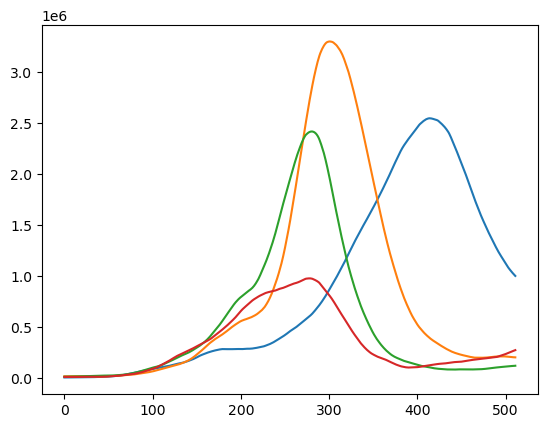

In [98]:
# %% Persistence silhouette

plt.figure()

for tind in [260, 275, 290, 305]:
    with open(f'./outputs/phase_space_trapped_tda/persistence_diagram_{tind}.pkl', 'rb') as f:
        p_all = pickle.load(f)

    pp_lower = []
    pn_lower = []
    pp_upper = []
    pn_upper = []

    for p_list in p_all:
        pp_lower.extend(p_list[0])
        pn_lower.extend(p_list[1])
        pp_upper.extend(p_list[2])
        pn_upper.extend(p_list[3])

    p1_lower = np.array(sorted(list(p[1] for p in (pp_lower+pn_lower) if p[0] == 1 and np.isfinite(p[1][1])), key=lambda p: p[0]-p[1]))

    SH = gudhi.representations.Silhouette(resolution=512, sample_range=[2.3e8, 3.3e8], weight=lambda x: np.power(np.abs(x[1]-x[0]),2))
    sh = SH.fit_transform([p1_lower])

    plt.plot(sh.T)

In [85]:
sh.shape

(1, 1000)